# Deterministic Interpolation using Inverse Distance Weighted

*Spatial interpolation is the process of estimating unknown values across space by making use of the values that we do know and using the assumptions that we can make based on Tobler's First Law of Geography. It may also sometimes be referred to as spatial predicition. Inverse Distance Weighted (IDW) interpolation is a deterministic interpolation method (meaning that the outputs for a given set of inputs will always be the same) that makes use of a fundamental mathematical concept in GIScience known as the Weighted Linear Combination (WLC).*

Last updated: Dec 1, 2023

In [1]:
# Imports
import os

os.environ["USE_PYGEOS"] = "0"

import contextily as ctx
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
from matplotlib import pyplot as plt
from shapely import Point

# IDW with Real-World Geospatial Data

When using fake coordinates and an artifical grid, we simplify the complexities of working with real geospatial data, where coordinate systems can cause many headaches and issues. In this exercise, we will take the lessons learned from implementing IDW on a simple dataset and bring it into the real-world scenario of interpolating air quality across the central part of Minneapolis (and deal with some coordinate system issues of our own).

### Reading in Observations

We have a simple dataset of air quality readings for 7 different sensors across Minneapolis stored in a CSV file, containing the latitude, longitude, and air quality value. Let's start by reading the file into a DataFrame/GeoDataFrame and transforming the coordinates from Lat/Long (EPSG: 4326) to Meters (EPSG: 3857).

In [2]:
# Create DataFrame of Known Values
known_df = pd.read_csv("./air_quality.csv")

known_df.head()

,lat,lon,aqi
0,44.965742,-93.285413,18.5
1,44.972718,-93.282235,19.1
2,44.960913,-93.261108,23.6
3,44.978421,-93.263571,22.5
4,44.984584,-93.267894,22.7


In [3]:
# Convert DataFrame to GeoDataFrame
known_gdf = gpd.GeoDataFrame(known_df, geometry = gpd.points_from_xy(known_df.lon, known_df.lat), crs = 4326)

known_gdf.head()

,lat,lon,aqi,geometry
0,44.965742,-93.285413,18.5,POINT (-93.28541 44.96574)
1,44.972718,-93.282235,19.1,POINT (-93.28224 44.97272)
2,44.960913,-93.261108,23.6,POINT (-93.26111 44.96091)
3,44.978421,-93.263571,22.5,POINT (-93.26357 44.97842)
4,44.984584,-93.267894,22.7,POINT (-93.26789 44.98458)


In [4]:
# Transform CRS from 4326 to 3857
known_gdf = known_gdf.to_crs(3857)

# Add New X/Y Columns
known_gdf["X"] = known_gdf.geometry.x
known_gdf["Y"] = known_gdf.geometry.y

known_gdf.head()

,lat,lon,aqi,geometry,X,Y
0,44.965742,-93.285413,18.5,POINT (-10384484.687 5616129.866),-1.038448e+07,5.616130e+06
1,44.972718,-93.282235,19.1,POINT (-10384130.929 5617227.512),-1.038413e+07,5.617228e+06
2,44.960913,-93.261108,23.6,POINT (-10381779.075 5615370.132),-1.038178e+07,5.615370e+06
3,44.978421,-93.263571,22.5,POINT (-10382053.204 5618124.901),-1.038205e+07,5.618125e+06
4,44.984584,-93.267894,22.7,POINT (-10382534.427 5619094.811),-1.038253e+07,5.619095e+06


In [5]:
# Coverting GeoDataFrame to List of Known Points
known_point_list = []

# Iterate through GeoDataFrame and Add to List
for _, row in known_gdf.iterrows():
    known_point_list.append(Point(row.X, row.Y, row.aqi))

# Display the Known Point List
print(known_point_list)

[<POINT Z (-10384484.687 5616129.866 18.5)>, <POINT Z (-10384130.929 5617227.512 19.1)>, <POINT Z (-10381779.075 5615370.132 23.6)>, <POINT Z (-10382053.204 5618124.901 22.5)>, <POINT Z (-10382534.427 5619094.811 22.7)>, <POINT Z (-10379179.394 5615661.707 23.1)>, <POINT Z (-10381414.073 5619549.962 23.3)>]


### Finding Bounds

Now that the points are transformed into projected coordinate system and in a better format, we are almost ready to start making predictions. First, we need to find the bounds of the known values so that we can create a fishnet within the bounding box of the known values. This fishnet will be where predictions are made.

In [6]:
# Find Bounds
bounds = known_gdf.total_bounds

# Find each Corner
xmin = bounds[0]
ymin = bounds[1]
xmax = bounds[2]
ymax = bounds[3]

### Making Predictions with IDW

Now we can implement the IDW logic on our fishnet. We will use while loops to make a prediction every 500 meters (in both X/Y directions) as long as we are within the bounds of the bounding box.

In [7]:
# Set Alpha Value for IDW
alpha = 2

# Create List for Storing Output
output = []

# Starting X/Y at bottom-left coordinate
x = xmin
y = ymin

# Tracking Number of Rows
rows = 0

In [8]:
# Nested While Loop to Iterate through all X/Y coordinates within the bounding box
while y < ymax:
    while x < xmax:
        # Set Starting Values for IDW Formula
        total_numerator = 0
        total_denominator = 0
        
        # Create Point Object for Current Point
        p = Point(x, y)
        
        # Iteratively Compare to each Known Point
        for kp in known_point_list:
            # Calculate Inverse Distance from Point to Known Point
            inv_dist = (1 / kp.distance(p))**alpha
            
            # Calculate Inverse Distance * the Known Point's Variable of Interest
            numerator_value = inv_dist * kp.z
            
            # Add Numerator for this Known Point to Total Numerator
            total_numerator += numerator_value
            
            # Add Inverse Distance for this Known Point to Total Denominator
            total_denominator += inv_dist
            
        # After all Known Points Iterated through, Calculate Predicition
        prediction = round((total_numerator / total_denominator), 2)
        
        # Append Tuple of (X, Y, Prediction) to Output List
        output.append((x, y, prediction))
        
        # Add 500m to X
        x += 500
    
    # Reset X back to start
    x = xmin
    
    # Add 500m to Y
    y += 500
    
    # Add 1 to Cols
    rows += 1

In [9]:
# Display the Output List
print(output)

[(-10384484.686976416, 5615370.132177142, 19.24), (-10383984.686976416, 5615370.132177142, 19.65), (-10383484.686976416, 5615370.132177142, 20.54), (-10382984.686976416, 5615370.132177142, 21.68), (-10382484.686976416, 5615370.132177142, 22.83), (-10381984.686976416, 5615370.132177142, 23.53), (-10381484.686976416, 5615370.132177142, 23.5), (-10380984.686976416, 5615370.132177142, 23.12), (-10380484.686976416, 5615370.132177142, 22.91), (-10379984.686976416, 5615370.132177142, 22.94), (-10379484.686976416, 5615370.132177142, 23.05), (-10384484.686976416, 5615870.132177142, 18.63), (-10383984.686976416, 5615870.132177142, 19.11), (-10383484.686976416, 5615870.132177142, 20.14), (-10382984.686976416, 5615870.132177142, 21.32), (-10382484.686976416, 5615870.132177142, 22.44), (-10381984.686976416, 5615870.132177142, 23.15), (-10381484.686976416, 5615870.132177142, 23.21), (-10380984.686976416, 5615870.132177142, 22.96), (-10380484.686976416, 5615870.132177142, 22.84), (-10379984.686976416

In [10]:
# Display Shape of Fishnet
print(f"Number of Predictions: {len(output)}")
print(f"Number of Rows: {rows}")
print(f"Number of Columns: {int(len(output)/rows)}")

Number of Predictions: 99
Number of Rows: 9
Number of Columns: 11


### Visualizing the Predictions

With predictions made, we can now visualize what they look like across space. To do this, we can convert the points to a GeoDataFrame and visualize them as points, or slightly change the settings of our point visualization to make it look similar to a raster.

In [11]:
# Convert Output to DataFrame
df = pd.DataFrame(output, columns = ["X", "Y", "VAL"])

df.head()

,X,Y,VAL
0,-1.038448e+07,5.615370e+06,19.24
1,-1.038398e+07,5.615370e+06,19.65
2,-1.038348e+07,5.615370e+06,20.54
3,-1.038298e+07,5.615370e+06,21.68
4,-1.038248e+07,5.615370e+06,22.83


In [12]:
# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.X, df.Y), crs = 3857)

gdf.head()

,X,Y,VAL,geometry
0,-1.038448e+07,5.615370e+06,19.24,POINT (-10384484.687 5615370.132)
1,-1.038398e+07,5.615370e+06,19.65,POINT (-10383984.687 5615370.132)
2,-1.038348e+07,5.615370e+06,20.54,POINT (-10383484.687 5615370.132)
3,-1.038298e+07,5.615370e+06,21.68,POINT (-10382984.687 5615370.132)
4,-1.038248e+07,5.615370e+06,22.83,POINT (-10382484.687 5615370.132)


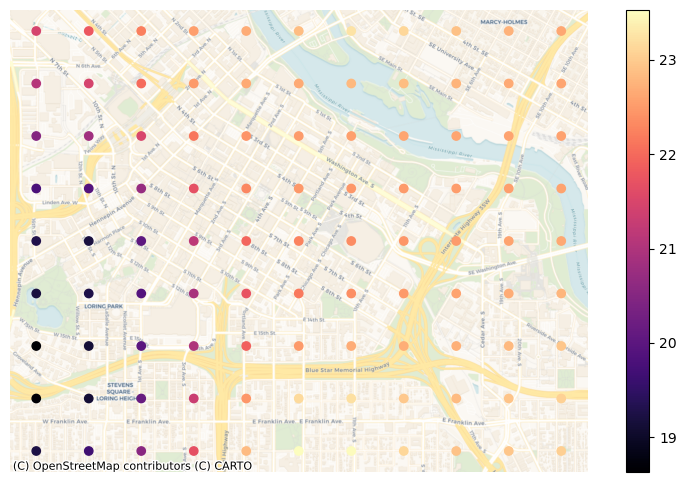

In [13]:
# Setting up Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plotting Points
gdf.plot(ax=ax, column = "VAL", legend = True, cmap = "magma")

# Adding Basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

# Turn Axes Off & Display
ax.axis("off")
plt.show()

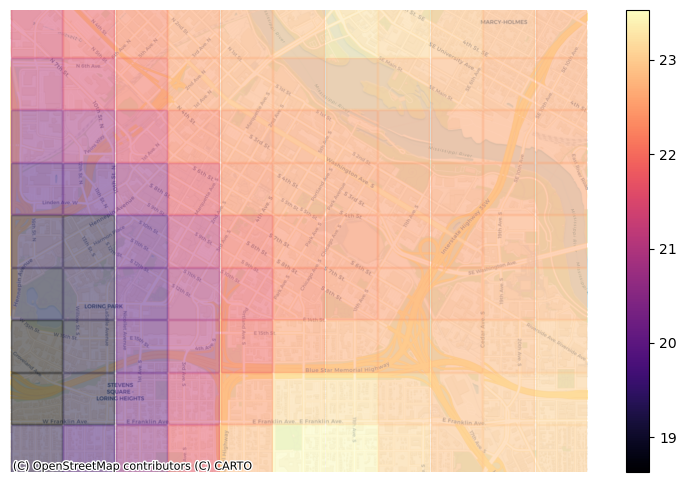

In [14]:
# Setting up Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plotting Points to look like a Raster
gdf.plot(ax=ax, column = "VAL", legend = True, cmap = "magma", marker="s", markersize=1350, alpha=0.5)

# Adding Basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

# Turn Axes Off & Display
ax.axis("off")
plt.show()

### Converting Predicted Points to a 2D Array

In addition to viewing the predictions as points (which are kind of like the centroids of raster cells), we can also convert the points to a two-dimensional array (a single-band raster). To do this, we need to use NumPy to sort and transform the data from a one-dimensional list into a two-dimensional array that is read from top-left to bottom-right.

In [15]:
# Sort Output by Y, X
sorted_output = sorted(output, key=lambda element: (element[1], element[0]))

In [16]:
# Remove Coordinates
sorted_values = [element[2] for element in sorted_output]

In [17]:
# Transform into 2D NumPy Array of size 9 x 11 (rows x columns)
array = np.reshape(np.array(sorted_values, dtype = "f"), (9, 11))

In [18]:
# Reorder Array to Correct Orientation (Starting at top-left)
flipped_array = np.flip(array, 0)

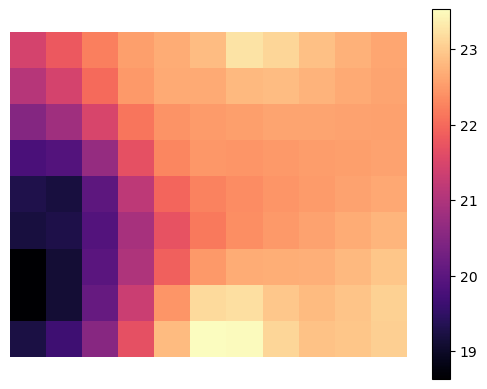

In [19]:
# Making a Basic Plot of the Array
plt.imshow(flipped_array, cmap = "magma")
plt.colorbar()
plt.axis("off")
plt.show()

### Converting 2D Array to Raster Dataset

With real geospatial data, we can also convert the two-dimensional array into a real raster file (GeoTIFF) that can be loaded into GIS Software like ArcGIS Pro or QGIS, as well as in Python through rasterio or GDAL/OSR.

There are limitations with this since the grid that we created is using Cartesian coordinates, which won't necessarily line up with the ellipsoidal nature of how projections actually work, but generally speaking it provides a dataset that is pretty close.

In [20]:
# Get Metadata about Raster
height = flipped_array.shape[0]
width = flipped_array.shape[1]

# Adjusted calculation for starting point (+/- half of the resolution)
x_start = xmin - 250
y_start = ymax + 250

# Create the transform (Resolution, 0, Starting X Coordinate, 0, -Resolution, Starting Y Coordinate)
transform = rasterio.Affine(500, 0, x_start, 0, -500, y_start)

# Create GeoTIFF
with rasterio.open(
    "./idw.tif",
    "w",
    driver = "GTiff",
    height = height,
    width = width,
    count = 1,
    dtype = "float32",
    crs = "EPSG:3857",
    transform = transform
) as r:
    r.write(flipped_array, 1)